In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

from pypower import PowerSpectrumMultipoles
from jaxpower import Spectrum2Poles, Spectrum3Poles, WindowMatrix

from abacus_hf import get_measurement_fn, get_box_measurement_fn

imock = 0
rebin = 5
catalog_args = dict(zsnap=0.725, region='NGC', tracer='LRG', zrange=(0.4, 0.6))
print(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum'))
#pypower = PowerSpectrumMultipoles.load(get_measurement_fn(imock=imock, region=region, kind='pypower'))
#pypower = pypower[:pypower.shape[0] // rebin * rebin:rebin]

nmocks = 25
pk_box = Spectrum2Poles.mean([Spectrum2Poles.load(get_box_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum')) for imock in range(nmocks)])
pk_box = pk_box.slice(slice(0, None, 5))

wmat_box = WindowMatrix.load(get_box_measurement_fn(imock=0, **catalog_args, kind='window_mesh2spectrum'))

wmat_square = wmat_box.slice(slice(0, None, 5), axis='o').slice(slice(0, None, 5), axis='t')
# Invert the square window matrix
observable_to_theory = wmat_square.clone(value=np.linalg.inv(wmat_square.view()),
                                         theory=wmat_square.observable, observable=wmat_square.theory)


/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/desipipe_test/AbacusSummit_base_c000_ph000/CutSky/LRG/mesh2spectrum_abacusHF_DR2_LRG_z0p725_z0.4-0.6_NGC.npy


In [2]:
pk_box_deconvolved = observable_to_theory.dot(pk_box.clone(num_shotnoise=None, norm=1.), return_type=None, zpt=False)
pk_box_deconvolved = pk_box.clone(num=pk_box_deconvolved.value).slice(slice(1, None))


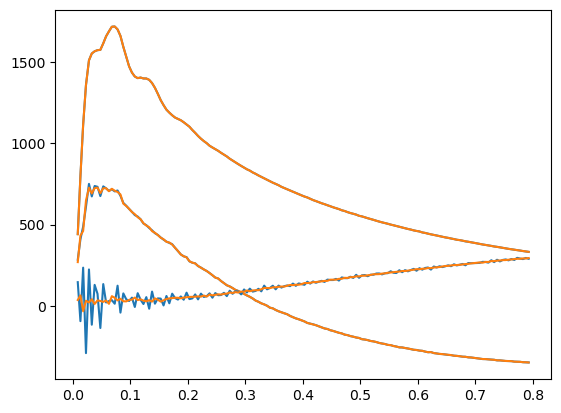

In [4]:
pk_box = pk_box.slice(slice(1, None))

k = pk_box.x(projs=0)
poles = [pk_box.view(projs=proj) for proj in pk_box.projs]
#np.savetxt('mean.txt', np.column_stack([k] + poles), fmt='%.9e', comments='# ', header='k P0 P2 P4')

k = pk_box_deconvolved.x(projs=0)
poles = [pk_box_deconvolved.view(projs=proj) for proj in pk_box.projs]
#np.savetxt('mean_deconvolved.txt', np.column_stack([k] + poles), fmt='%.9e', comments='# ', header='k P0 P2 P4')


ax = plt.gca()
for proj in pk_box.projs:
    k = pk_box.x(projs=0)
    ax.plot(k, k * pk_box.view(projs=proj), color='C0')
    k = pk_box_deconvolved.x(projs=0)
    ax.plot(k, k * pk_box_deconvolved.view(projs=proj), color='C1')
plt.show()

In [ ]:
fn = '/global/cfs/cdirs/desi/mocks/cai/holi/v1/lrg/v1.0/lrg_real12_full_sky.npz'
import numpy as np
data = np.load(fn)
plt.hist(data['z'], bins=20),

In [ ]:
spectrum = Spectrum3Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh3spectrum_scoccimarro'))

kmin = 0.
ax = plt.gca()
ax.plot([], [], color='k', linestyle='-', label='jaxpower')
for ill, ell in enumerate(spectrum.projs):
    color = 'C{:d}'.format(ill)
    x = np.prod(spectrum.xavg(projs=ell, method='mid'), axis=-1)
    ax.plot(x[1:] * spectrum.view(projs=ell).real[1:], color=color, linestyle='-')
ax.set_xlabel(r'index')
ax.set_ylabel(r'$k_1 k_2 k_3 B_{\ell}(k_1, k_2, k_3)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
from abacus_hf import get_clustering_rdzw, get_data_fn, get_randoms_fn

fn = get_data_fn(**catalog_args)
data = get_clustering_rdzw(fn, **catalog_args)
ax = plt.gca()
bins = 20
ax.hist(data[2], bins=bins, density=True, histtype='step', label='data')
fn = get_randoms_fn()
randoms = get_clustering_rdzw(fn, **catalog_args)
ax.hist(randoms[2], bins=bins, density=True, histtype='step', label='randoms')
plt.show()

In [ ]:
def plot_healpix(ra, dec, nside=64, title="Binned RA/DEC Map", show=True):
    import healpy as hp
    npix = hp.nside2npix(nside)
    # Convert to theta (colatitude) and phi (longitude) in radians
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra + 180.)
    # Get pixel indices
    pix = hp.ang2pix(nside, theta, phi)
    # Bin into HEALPix map
    healpix_map = np.bincount(pix, minlength=npix)
    # Mask unseen pixels
    healpix_map = np.where(healpix_map == 0, hp.UNSEEN, healpix_map)
    # Plot
    hp.mollview(healpix_map, title=title, unit="Counts", cmap="viridis")
    if show:
        plt.show()

plot_healpix(*data[:2])
plot_healpix(*randoms[:2])